In [1]:

import cartopy.crs as ccrs # just for plotting
from glob import glob
import matplotlib.pyplot as plt # just for plotting
import numpy as np
import pandas as pd
from pygris import counties, states
import xarray as xr # also need to install netcdf4 and dask[complete]
import os
from io import BytesIO
import time
from datetime import datetime
import re

In [2]:
# prepare dataset of counties and states for subsetting

# CONUS states
conus_states = states(cb=True, year=2020, cache=True).to_crs("epsg:4326")
conus_states = conus_states[~conus_states.NAME.isin([
    'Alaska','American Samoa','Puerto Rico','United States Virgin Islands',
    'Hawaii','Guam','Commonwealth of the Northern Mariana Islands',
])]

# CONUS counties
conus_counties = counties(cb=True, year=2020, cache=True).to_crs("epsg:4326")
conus_counties = conus_counties[conus_counties.STATEFP.isin(
    conus_states.STATEFP
)]


In [3]:
# method to fix the weird WRF indexing
# and load the time/space dimensions into memory
def preprocess(d):
    d = d.rename_dims({
        'Time': 'time',
    }).rename_vars({
        'XLAT': 'lat',
        'XLONG': 'lon',
    })
    d['time'] = pd.to_datetime(
        d.Times.load().astype(str).str.replace('_', ' ')
    )
    d = d.drop_vars(['Times'])
    d['lat'] = d.lat.isel(time=0).load()
    d['lon'] = d.lon.isel(time=0).load()
    return d


In [4]:
def get_tgw_subset(
    *,
    start: str, # 'YYYY-MM-DD' or 'YYYY-MM-DDTHH:MM:SS'
    end: str, # 'YYYY-MM-DD' or 'YYYY-MM-DDTHH:MM:SS'
    county_fips: str = None, # county FIPS code to keep, None for all
    state_abbreviation: str = None, # State abbreviation to keep, None for all
    min_lat: float = None, # minimum latitude in WGS84 (epsg:4326)
    max_lat: float = None, # maximum latitude in WGS84 (epsg:4326)
    min_lon: float = None, # minimum longitude in WGS84 (epsg:4326)
    max_lon: float = None, # maximum longitude in WGS84 (epsg:4326)
    variables = None, # list of variables to keep, None for all
    data_glob = './data/*.nc', # glob to all the data files
    load = True, # if True, load the data before returning; otherwise return the chunked dask dataset
    write_to_file = False, # if a path, write subset to that path; if False don't
):

    # NOTE that certain variables (precipitation, etc) are presented as "cumulative",
    #      meaning that the user may actually need one timestep before the requested
    #      start time in order to fully resolve those variables
    # TODO this is not accounted for in this method

    # NOTE that the WRF data presented in WGS84 (epsg:4326) projection as is the case
    #      here is NOT on a rectilinear grid, which can be confusing to work with, but
    #      the native WRF projection IS on a rectilinear grid but those coordinates are
    #      not provided by default (see the python package salem for more details...)

    # NOTE the data_glob must be used to filter by scenario,
    #      but users may benefit from a wrapper for that functionality too

    # collect and sort paths to all the files
    # assumes the sorting by filename correctly orders files by time
    all_files = sorted(glob(data_glob))

    # subset to the necessary years of data
    # doesn't account for requested years not found in the data
    # one could make this more sophisticated for higher efficiency
    # i.e. by dealing with months and weeks too
    # assumes filenames unambiguously have years in them...
    date_start = datetime.strptime(start, '%Y-%m-%d')
    date_end = datetime.strptime(end, '%Y-%m-%d')
    files_for_dates = []
    lastindex=-1
    for index, filename in enumerate(all_files):
        # tgw_wrf_rcp85hotter_hourly_2088-01-01_01_00_00.nc
        match = re.search(r'\d{4}-\d{2}-\d{2}', filename)
        date_str = match.group()
        file_date = datetime.strptime(date_str, '%Y-%m-%d')
        if file_date >= date_start and file_date < date_end:
            files_for_dates.append(filename)
            lastindex = index
    
    if lastindex+1 < len(all_files) -1 and lastindex != -1:
        files_for_dates.append(all_files[lastindex+1])

    # open the files with dask chunks
    # TODO may be more efficient chunking method than the default...
    # d = xr.open_mfdataset(files_for_dates, parallel=True, preprocess=preprocess)
    
    combined_dataset = None
    for filename in files_for_dates:
        file_start_time = time.time()
        with open(filename, "rb") as file:
            data = BytesIO(file.read())
            file_end_time = time.time()
            print(f"Time taken to read file {filename}: {file_end_time - file_start_time} seconds")
            file_start_time = time.time()
            d = xr.open_dataset(data, chunks={'Time': 100})
            d = preprocess(d)
            file_end_time = time.time()
            print(f"Time taken to xr open and preprocess file {filename}: {file_end_time - file_start_time} seconds")
            if combined_dataset is None:
                combined_dataset = d
            else:
                file_start_time = time.time()
                combined_dataset = xr.merge([combined_dataset, d])
                file_end_time = time.time()
                print(f"Time taken to merge file {filename}: {file_end_time - file_start_time} seconds")

    d = combined_dataset     
    # subset by variables
    # TODO may help to ignore or just warn about requested variables that don't
    #      exist, rather than just fail
    if variables is not None:
        d = d[variables]
    
    # subset by date
    d = d.sel(time=slice(start, end))

    # subset by space
    # NOTE that there could be errors caused by use of -180 to 180 vs 0 to 360 nomenclature
    # TODO may want to build in a buffer to be sure to catch the edges of the shape
    if (state_abbreviation is not None):
        state_bounds = conus_states[conus_states.STUSPS == state_abbreviation.upper()].bounds.iloc[0]
        d = d.where(
            (d.lat>=state_bounds.miny) &
            (d.lat<=state_bounds.maxy) &
            (d.lon>=state_bounds.minx) &
            (d.lon<=state_bounds.maxx),
            drop=True,
        )
    if (county_fips is not None):
        county_bounds = conus_counties[conus_counties.GEOID == county_fips].bounds.iloc[0]
        d = d.where(
            (d.lat>=county_bounds.miny) &
            (d.lat<=county_bounds.maxy) &
            (d.lon>=county_bounds.minx) &
            (d.lon<=county_bounds.maxx),
            drop=True,
        )
    if (min_lat is not None) or (max_lat is not None) or (min_lon is not None) or (max_lon is not None):
        d = d.where(
            (d.lat>=(min_lat if min_lat is not None else -np.Inf)) &
            (d.lat<=(max_lat if max_lat is not None else np.Inf)) &
            (d.lon>=(min_lon if min_lon is not None else -np.Inf)) &
            (d.lon<=(max_lon if max_lon is not None else np.Inf)),
            drop=True,
        )

    # write the data to file if requested
    if write_to_file:
        d.to_netcdf(write_to_file)

    # loading the data fully into memory takes some time
    # a user skilled with dask may benefit from keeping the data unloaded
    # until the end of their data transformations
    if load:
        return d.load()
    return d
    

In [5]:
%%time
HOME = os.environ.get("HOME")
DATA_DIR = os.path.join(HOME, "data/s3")
d = get_tgw_subset(
    start='2088-01-01',
    end='2088-02-01',
    variables=['T2'],
    # county_fips='53033',
    state_abbreviation='wa',
    # min_lat=45.543830,
    # max_lat=49.002405,
    # min_lon=-124.7336,
    # max_lon=-116.9161,
    data_glob=f'{DATA_DIR}/*.nc',
    load=False,
    write_to_file='./subset.nc',
)

In [6]:
# look at the subset
d

<xarray.Dataset> Size: 7MB
Dimensions:  (time: 744, south_north: 44, west_east: 56)
Coordinates:
    lat      (south_north, west_east) float32 10kB 44.25 44.28 ... 50.17 50.19
    lon      (south_north, west_east) float32 10kB -124.2 -124.0 ... -117.5
  * time     (time) datetime64[ns] 6kB 2088-01-01T01:00:00 ... 2088-02-01
Dimensions without coordinates: south_north, west_east
Data variables:
    T2       (time, south_north, west_east) float32 7MB dask.array<chunksize=(1, 44, 56), meta=np.ndarray>
Attributes: (12/142)
    TITLE:                            OUTPUT FROM WRF V4.2.1 MODEL
    START_DATE:                      2088-01-01_00:00:00
    SIMULATION_START_DATE:           2059-01-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        425
    SOUTH-NORTH_GRID_DIMENSION:      300
    BOTTOM-TOP_GRID_DIMENSION:       33
    ...                              ...
    ISLAKE:                          -1
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

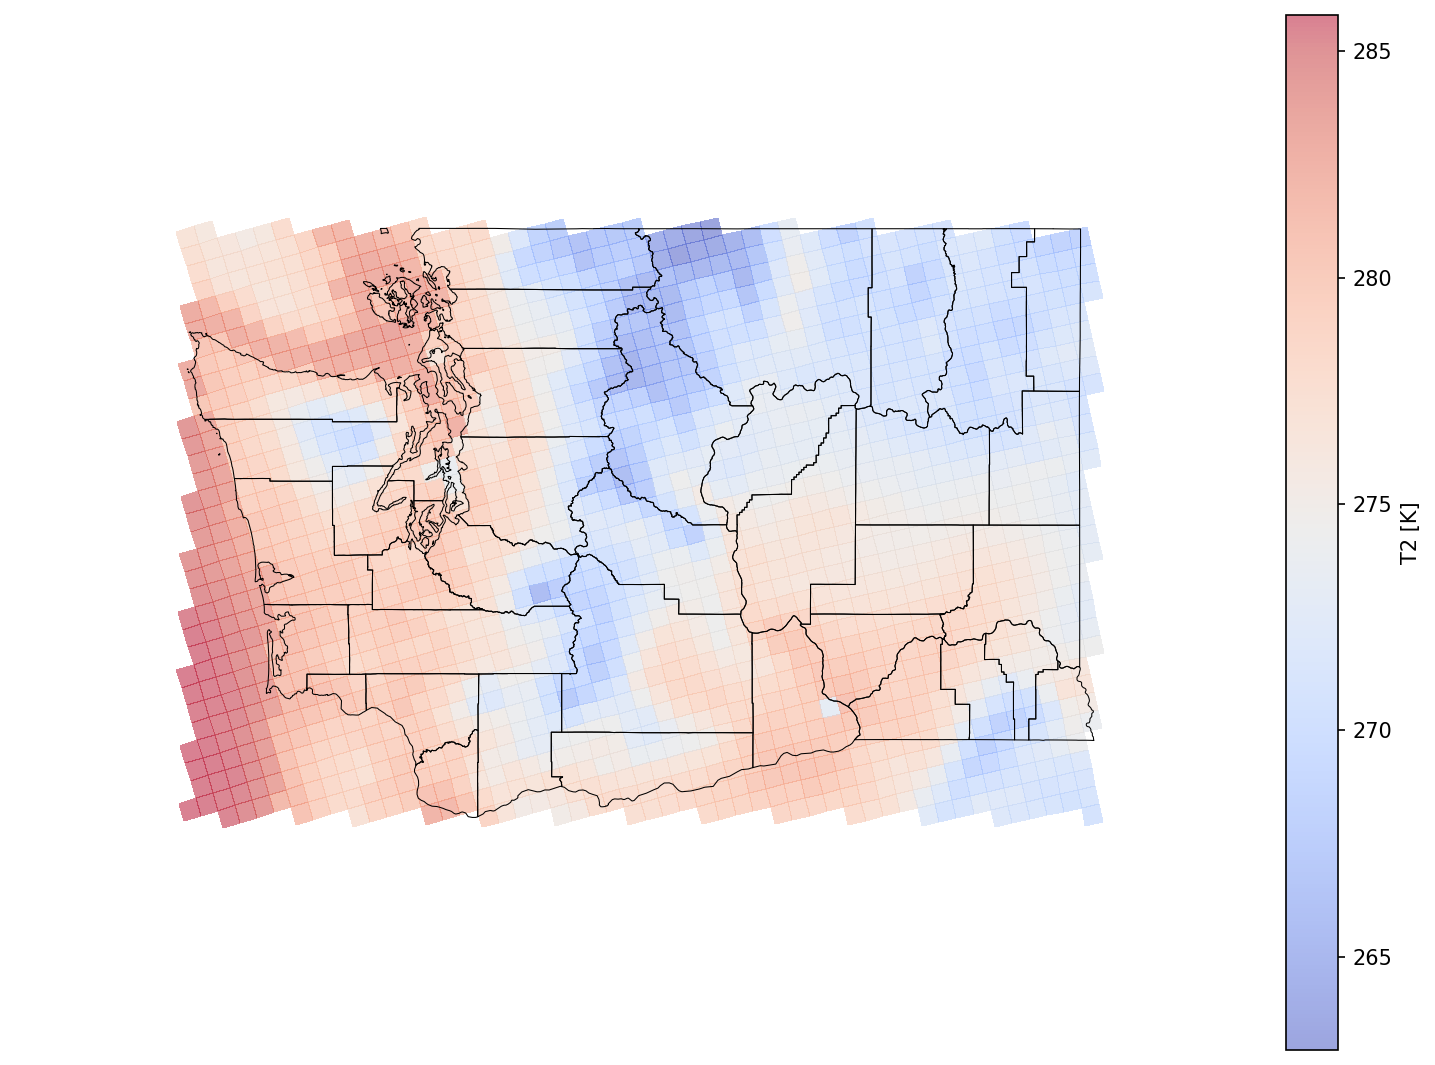

In [7]:
# plot the subset in the usual WGS84 datum
%%time
fig = plt.figure(figsize=(10.8, 7.2), dpi=150, layout='tight')
ax = plt.axes(projection=ccrs.PlateCarree(), frameon=False)
conus_counties[conus_counties.STUSPS == 'WA'].boundary.plot(ax=ax, transform=ccrs.PlateCarree(), linewidth=0.5, color='black')
d.isel(time=0).T2.plot(ax=ax, transform=ccrs.PlateCarree(), x="lon", y="lat", alpha=0.5, cmap='coolwarm')
ax.set_title('');

In [ ]:
# plot the subset in the TGW-WRF native projection
# '+proj=lcc +lat_0=40.0000076293945 +lon_0=-97 +lat_1=30 +lat_2=45 +x_0=0 +y_0=0 +R=6370000 +units=m +no_defs'
%%time
tgw_crs = ccrs.LambertConformal(
    central_longitude=-97.0,
    central_latitude=40.0000076293945,
    standard_parallels=(30, 45),
    globe=None,
)
fig = plt.figure(figsize=(10.8, 7.2), dpi=150, layout='tight')
ax = plt.axes(projection=tgw_crs, frameon=False)
conus_counties[conus_counties.STUSPS == 'WA'].boundary.plot(ax=ax, transform=ccrs.PlateCarree(), linewidth=0.5, color='black')
d.isel(time=0).T2.plot(ax=ax, transform=ccrs.PlateCarree(), x="lon", y="lat", alpha=0.5, cmap='coolwarm')
ax.set_title('');